Léo Tarbouriech

# Project Computational Sciences: Protein Sequences

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/PCS_CompSci_Project')
# import sklearns
# print(sklearn.__version__)

# #!pip install --upgrade --force-reinstall scikit-learn==1.3.2

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

from dataclasses import dataclass
import matplotlib.ticker as mticker
import copy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Task 1: One Hot Encoding

### A) Class that handles the protein sequences

In [8]:
class sequence_data:
    '''
    This class allow to handle the sequence data. It implements also some basic manipulations like merging two datasets.
    It does the preprocessing task of reading the files and encoding the sequences.
    '''
    name: str
    designM: np.array       # each line corresponds to a data point, each column to a feature, this the convention in sklearn
    label_funct: np.array   # contains the labels, i.e. the "function_true" or "functional_false" bool, each line is a data point
    label_natural: np.array # wether the dataset is natural or not
    label_seq: np.array     # original sequence of peptides
    _ch: list               # the list of petides name
    _dict: dict             # a dictionary to encode the peptides
    _dict_decode: dict      # dictionnary to decode the sequences


    def __init__(__self__,namein: str, filename: str, label: bool) -> None:
        '''
        This is the contructor of the class. It only runs `load_dataset` and give a name to the class.
        Inputs:
            namein: name of the dataset (any label the user wants to use)
            filename: name of the file that contains the dataset (provide relative or absolute os path)
            label: wether the sequences in the file are natural or not (this loading procedure cannot handle a file containing mixed natural and artificial sequences)
        '''
        name = namein
        __self__._ch=["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
        __self__._dict={str(__self__._ch[i]):i for i in range(len(__self__._ch))}
        __self__._dict_decode={i:str(__self__._ch[i]) for i in range(len(__self__._ch))}
        __self__.load_dataset(filename, label)
        

    def load_dataset(__self__, filename: str, label: bool) -> None:
        '''
        Read the file provided as filename and fill al the labels of the dataset, based on user provided information and on information found in the file
        Inputs:
            filename: see the constructor
            label: see the constructor
        '''
        draftM=[]
        draftLab=[]
        draftSeq=[]
        with open(filename) as f:
            lines = f.readlines()
            for i in range(0,len(lines), 4):
                draftLab.append(1 if 'functional_true' in lines[i] else 0 if 'functional_false' else None)
                line=lines[i+1][:-1]+lines[i+2][:-1]
                draftM.append(__self__.encode_seq(line))
                draftSeq.append(line)

        __self__.designM=np.array(draftM)
        __self__.designM.reshape((len(draftM),1920))
        __self__.label_funct=np.array(draftLab)
        __self__.label_funct.reshape((len(draftLab),1))
        __self__.label_natural=np.array([label]*len(draftM))
        __self__.label_natural.reshape((len(draftM),1))
        __self__.label_seq=np.array(draftSeq)
        __self__.label_seq.reshape((len(draftSeq),1))
    
    def encode_seq(__self__,line: str) -> list:
        '''
        Implements one hot encoding for the dataset
        '''
        code=[]                        # 'code' will contain the code of a full peptide
        # Create a dictionary to translate from peptide sequence to one-hot
        #__seft__._ch=["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
        #__self__._dict={str(ch[i]):i for i in range(len(ch))}
        
        for c in line:
            minicode=[0]*20            # minicode will contain the code for one letter (one peptide of the protein)
            if not c=='-':
                minicode[__self__._dict[c]] = 1
            for m in minicode:
                code.append(m)
        return code
    
    def decode_seq(__self__, code):
        '''
        Implements the inverse of the preceding function. For any one hot encoded sequence
        '''
        if len(code)%20!=0:
            raise ValueError("The length of the code is not divisible by 20, this is not a valid code for an amino acide sequence")
        output = ""

        for i in range(len(code)//20):
            minicode=list(code[20*i:20*i+20])
            if minicode==20*[0]:
                output+="-"
                continue
            if minicode.count(1)!=1:
                raise ValueError("The sequence is not a valid sequence for an amino acid. \n Each block of twenty digits should contain no more thant one 1:",minicode)
            c=minicode.index(1)
            output+=__self__._dict_decode[c]
        return(output)

    def merge(__self__, name: str, *listSeq):
        '''
        Takes as arguments instances of the class `sequence_data` and built a new instance of this class which is the merged `sequence_data`.
        It merges the datasets provided as arguments and retruns a new dataset. The `__self__` is not modified.
        Inputs: 
            listSeq --> any number of `sequence_data` that will be merged
            name --> the nama to give to the new `sequence_data`
        '''
        newname = name
        designM = __self__.designM.copy()
        label_funct = __self__.label_funct.copy()
        label_natural = __self__.label_natural.copy()
        label_seq = __self__.label_seq.copy()
        for seq in listSeq:
            designM = np.concatenate((designM, seq.designM))
            label_funct = np.concatenate((label_funct, seq.label_funct))
            label_natural = np.concatenate((label_natural, seq.label_natural))
            label_seq = np.concatenate((label_seq, seq.label_seq))
        output = copy.deepcopy(__self__)
        output.designM = designM
        output.label_natural = label_natural
        output.label_funct = label_funct
        output.label_seq = label_seq
        return output

## Load dataset

In [9]:
# Create the sampless for natural and artificial sequences
seq_nat=sequence_data('Natural','MSA_nat_with_annotation.faa',True)
seq_art = sequence_data('Artificial Sequence','MSA_art.faa',False)
seq_merged = seq_nat.merge('Merged',seq_art)

In [10]:
# Load samples
X_train, X_test, Y_train, Y_test = train_test_split(seq_merged.designM, seq_merged.label_funct, test_size=0.2)

pca2 = PCA(2)
pca2.fit(seq_nat.designM);

## A EBM model

In [11]:
from sklearn.covariance import empirical_covariance
from sklearn.utils import shuffle
from numpy.random import randint, random

In [12]:
class sk_model:
    data: np.array        # the dessign matri of the problem
    fantasy: np.array     # dessign matrix like but for fantassy particles
    J: np.array           # array representing coupling between the aminoacides it is the inverse of the corelation matrix
    data_freq: np.array   # frequency of o each amino acid at each position, would be usefull for entropy ranking access

    def __init__(__self__,data: np.array) -> None:
        __self__.data = data
        __self__.fantasy = np.zeros(shape=(0,data.shape[1]), dtype=float)
        __self__.J = np.linalg.pinv(empirical_covariance(data))
        __self__.data_freq = __self__._freq_from_data(data)

    def _freq_from_data(__self__, data: np.array) -> np.array:
        frequency = data.sum(axis=0)
        frequency.dtype=float

        for i in range(0,len(frequency)//20):
            frequency[i*20:(i+1)*20] = frequency[i*20:(i+1)*20] / frequency[i*20:(i+1)*20].sum()

        return frequency 
    
    def _proba(__self__, idx: int, AApos: int, loc_S, loc_J) -> float:
        '''
        When idx in (0,20(, returns the probability of the ith feature to be non zero, knowing the other featuress.
        When idx == 20, it evaluates the probability to have all the feature repreneting an aminoacide
        equal to zero.
        The probability that is retruned is the probability to have the amino-acide `idx` (from 0to 19 -> A to Y and 20 -> -)
        at position `AApos` conditioned on the rest of the sequence

        Inputs:
            idx          -> index of the one hot encoded amino acid that is set to one, btw 0 and 20 included
            AApos        -> position of the amino acid in the chain
            S            -> a vector size n_feature that gives the initial configuration of the amino acid sequence
        '''
        Z = 1 + (np.exp( - np.longdouble( loc_J @ loc_S ) )[20*AApos:20*AApos+idx]).sum()

        if idx==20:
            w=1
        else:
            w = np.exp( - np.longdouble( ( loc_J @ loc_S) )[20*AApos+idx] )
        
        return( np.longdouble(w / Z) )
    
        # proba=0
        # if idx < 20:
        #     proba=frequency[20*AApos+idx]
        # else:
        #     proba = 1 - frequency[20*AApos:20*(AApos+1)].sum()
        # return proba
    
    def _sanity(__self__,vec: np.array) -> None:
        '''
        Check that a vector is a consistant amino acid sequence
        '''
        num_hot = vec.sum()
        num_o = ( np.ones(shape=vec.shape) - vec ).sum()
        
        if vec.shape != (1920,):
            raise(ValueError('The sequence has not the shape expected for an aminoacid'))
        if num_o + num_hot != 1920:
            raise(ValueError('The sequence contains something else than 0 and 1'))
        if num_hot > 96:
            raise(ValueError('The Sequence Contains to many ones'))
        
    def _idx_fromEnt(idx: int):
        '''
        idx is the index of an aminocid in the sequence. `_idx_fromEnt` returns the true index it has on the sequence based on the entropy
        '''
        n_AA = __self__.data.shape[1] // 20
        entropies = np.zeros((n_AA,))
        for i in range(n_AA):
            entropies[i] = ( __self__.data_freq[20*i:20*(i+1)]*np.log(__self__.data_freq[20*i:20*(i+1)]) ).sum()
        dict = {}
        for i, entropy in enumerate(entropies):
            dict |= {entropy:i}
        
        dict2 = {}
        sorted_entropy = entropy.sort()
        for i, entropy in enumerate(sorted_entropy):
            dict2 |= {i : dict[entropy]}
        
        return dict2[idx]

    
    def gibbs_sampler(__self__, initS, initJ, n_samples=1, n_gibbs_step=10, n_dropout=100) -> np.array:
        '''
        Generate samples via gibbs sampling

        Inputs:
            initS         -> initialisatial state of the Si, typically a fantasy particle or a data point chossen randomly
            initJ         -> typically the current value of J, can be J computed from a batch of data or fantassy partcile or mixed
            n_samples     -> number of samples to generate
            n_gibbs_steps -> number of component to update via gibbs sampling at each iteration
            n_dropout     -> number of steps that should be droppe dout after initialisation of the sampler we consider that
                            after this step an equilibrium is reached and the data point geenrated reflect the probability distribution.
                            Typically n_dropout~1000
        '''
        n_update = 0 # counts all the updates
        n_gibbs = 0  # counts the gibbs states (i.e. is reset to zero when a conffiguration is accepted)
        n_fantasy = 0
        S = initS
        local_fantasy = np.zeros(shape=(0,initS.shape[0]))

        while n_fantasy < n_samples:
            # Loop over the one-hot representation of the protein
            # To speed up the code, we have chosen to not change all the protéin structure between two points of the 
            # Markov Chain. We do changes at n_gibbs_steps position of the protein
            for i in range(len(initS)//20):
                idx = randint(0,21) # one should rather use the box-Mueller algorithm
                rnd = random()
                p=__self__._proba(idx, i, loc_S=S ,loc_J=initJ)
                
                # print('iterations: ',i,idx, n_fantasy,p)
                if rnd < p:
                    n_update +=1
                    n_gibbs +=1
                    if idx == 20:
                        S[20*i: 20*(i+1)] = np.array([0]*20)
                    else:
                        S[20*i: 20*(i+1)] = np.array([0]*20)
                        S[20*i + idx] = 1

                # Do not retain the first configuration to be sure we reached equilibrium
                # Keep as a fantasy particle only one over a certain number of steps
                if n_update < n_dropout or n_gibbs < n_gibbs_step : continue

                # when a configuration is accepted we reset n_gibbs to zero
                n_gibbs=0
                local_fantasy = np.concatenate((local_fantasy, S.reshape((1,local_fantasy.shape[1])) ), axis=0)
                __self__._sanity(S)
                n_fantasy+=1
        
        return local_fantasy

    def correlation_matrice(__self__, designM: np.array) -> np.array:
        '''
        Given a matrice that is data-like / design matrice-like, returns the matrice of correlation between the datapoints
        '''
        return empirical_covariance(designM)

    def fit_sgd(__self__, batch_size=10, eta=0.001, maxiter=100, tol=1.e-4) -> None:
        '''
        Implements the gradient descent alogorithm
        Change the value of J to the fitted one
        '''
        for i in range(maxiter):
            local_fantasy = __self__.gibbs_sampler( initS = __self__.data[0, :], initJ=__self__.J, n_samples = batch_size)
            local_data = shuffle(__self__.data)[0:batch_size, :]
            grad = empirical_covariance(local_data) - empirical_covariance(local_fantasy)
            oldJ = __self__.J
            __self__.J = __self__.J - eta*grad

            if ( (__self__.J - oldJ) * (__self__.J - oldJ) ).all() <= tol:
                print("The fit have converged")
                break
            print('Warning: the fit has not converged, it was stopped by maxiter')

In [13]:
model=sk_model(seq_nat.designM)
fantasy=model.gibbs_sampler(model.data[0,:], model.J, n_samples=100, n_gibbs_step=10, n_dropout=10)

Text(0.5, 1.0, 'Design Matrix of generated data')

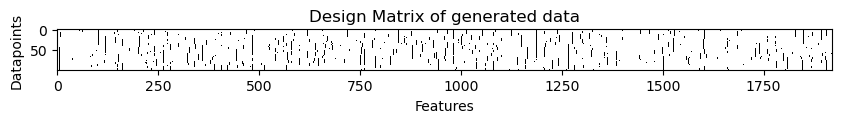

In [14]:
#figure of the desugn matrix
fig2, ax2 = plt.subplots(figsize=(10,10))

ax2.imshow(fantasy, cmap='binary', interpolation='none')

ax2.set_ylabel('Datapoints')
ax2.set_xlabel('Features')
ax2.set_title('Design Matrix of generated data')

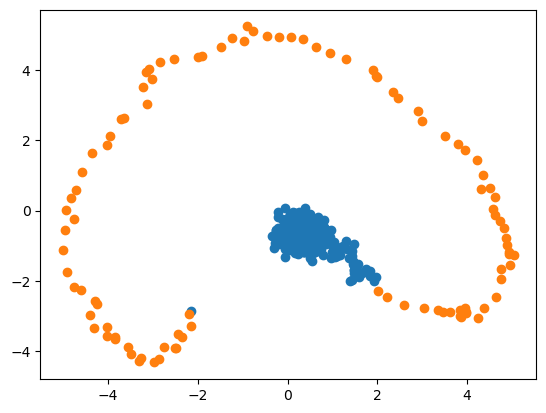

In [15]:
from sklearn.decomposition import PCA
pca = PCA(2)
twDfanta=pca.fit_transform(fantasy)
twDdata=pca.transform(seq_nat.designM)
plt.scatter(twDdata[:,0], twDdata[:,1], )
plt.scatter(twDfanta[:,0], twDfanta[:,1])

In the example above, we have just generated ssamples without any traing, we have kept all the geenrated vonfigurations. We see the path that have been followed by the Gibbs sampling and we see that it relaxes slowly towards the bulk of the distribution of natural sequences. Our algorithm iss apparetly not very efficient because starting from a point that is far form the rest on the point,, it takes a very long time to relax towards the bulk distribution.

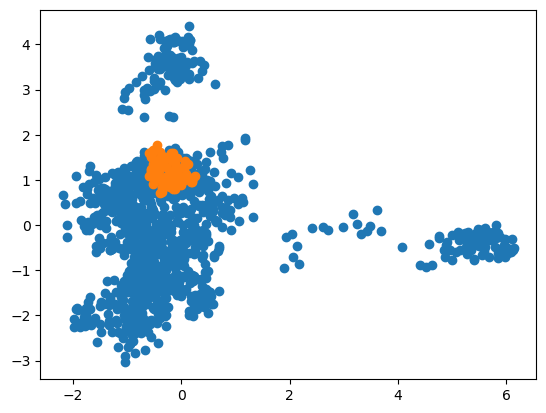

In [16]:
from sklearn.decomposition import PCA
pca = PCA(2)
twDdata=pca.fit_transform(seq_nat.designM)
twDfanta=pca.transform(fantasy)
plt.scatter(twDdata[:,0], twDdata[:,1])
plt.scatter(twDfanta[:,0], twDfanta[:,1])

## An EBM model on a Potts lattice

In the article:
``````
Trinquier, J., Uguzzoni, G., Pagnani, A. et al. Efficient generative modeling of protein sequences using simple autoregressive models. Nat Commun 12, 5800 (2021). https://doi.org/10.1038/s41467-021-25756-4
``````

A similar model is reported to be very efficient at generating artificial protein sequences. The difference with the provoius model is 
1) that the amino acids are considered to be correlated only from the ont that has lowest entropy to the one that has highest entropy. This means that Jij is block triangular superior per bloc if the sequences are ordered from the higest entropy to lowest entropy.
2) the presence of `magnetic` field that plais the role of setting the averange value of S and thus also the marginal probability distribution of the aminoacide at each site.
3) The model is regularised with an L2 regularisation for h and J

We propose below an implementation of such an aproach, but without the régularisation. In the current state, this does not work do generate new sequence.

In [17]:
class sk_model2:
    data: np.array        # the dessign matrix of the problem
    fantasy: np.array     # dessign matrix like but for fantassy particles
    J: np.array           # array representing coupling between the aminoacides it is the inverse of the corelation matrix
    h: np.array
    data_freq: np.array   # frequency of o each amino acid at each position, would be usefull for entropy ranking access

    def __init__(__self__,data: np.array) -> None:
        __self__.data = data
        __self__.fantasy = np.zeros(shape=(0,data.shape[1]), dtype=float)
        __self__.J = np.linalg.pinv(empirical_covariance(data))
        __self__.h = np.random.rand(1,data.shape[1])
        __self__.data_freq = __self__.frequency(data)
    
    def _proba(__self__, idx: int, AApos: int, loc_S, loc_J, loc_h) -> float:
        '''
        When idx in (0,20(, returns the probability of the ith feature to be non zero, knowing the other featuress.
        When idx == 20, it evaluates the probability to have all the feature representing an aminoacide
        equal to zero.
        The probability that is returned is the probability to have the amino-acide `idx` (from 0to 19 -> A to Y and 20 -> -)
        at position `AApos` conditioned on the rest of the sequence

        Inputs:
            idx          -> index of the one hot encoded amino acid that is set to one, btw 0 and 20 included
            AApos        -> position of the amino acid in the chain
            S            -> a vector size n_feature that gives the initial configuration of the amino acid sequence
        '''
        Z = 1 + (np.exp( - np.longdouble( loc_J @ loc_S + loc_h@loc_S) )[20*AApos:20*AApos+idx]).sum()

        if idx==20:
            w=1
        else:
            w = np.exp( - np.longdouble( ( loc_J @ loc_S + loc_h@loc_S) )[20*AApos+idx] )
        
        return( np.longdouble(w / Z) )
    
        # proba=0
        # if idx < 20:
        #     proba=frequency[20*AApos+idx]
        # else:
        #     proba = 1 - frequency[20*AApos:20*(AApos+1)].sum()
        # return proba

    def _sanity(__self__,vec: np.array) -> None:
        '''
        Check that a vector is a consistant amino acid sequence
        '''
        num_hot = vec.sum()
        num_o = ( np.ones(shape=vec.shape) - vec ).sum()
        
        if vec.shape != (1920,):
            raise(ValueError('The sequence has not the shape expected for an aminoacid'))
        if num_o + num_hot != 1920:
            raise(ValueError('The sequence contains something else than 0 and 1'))
        if num_hot > 96:
            raise(ValueError('The Sequence Contains to many ones'))

    def _idx_fromEnt(__self__,entidx: int):
        '''
        idx is the index of an aminocid in the sequence. `_idx_fromEnt` returns the true index it has on the sequence based on the entropy
        '''
        eps=1e-18
        n_AA = __self__.data.shape[1] // 20
        entropies = np.zeros((n_AA,))
        for i in range(n_AA):
            a=( -__self__.data_freq[20*i:20*(i+1)]*np.log(__self__.data_freq[20*i:20*(i+1)]+eps) ).sum()
            if np.isnan(a):
                a=0
            entropies[i] = a
        
        dtype1 = [('idx', int), ('ent',np.double)]
        list1 = []
        for i, entropy in enumerate(entropies):
            list1.append((i,entropy))
        dict1 = np.array(list1, dtype=dtype1)
        dict2 = np.sort(dict1, order='ent')
        return dict2[entidx]['idx']

    def _conditionJ(__self__,J: np.array):
        for k in range(len(J)//20):
            i = __self__._idx_fromEnt(k)
            for l in range(k-1):
                j = __self__._idx_fromEnt(l)
                J[20*i:20*(i+1),20*j:20*(j+1)]=0
            
            # for m in range(20):
            #     for l in range(m):
            #         J[20*i+m,20*i+l]=0
            #         J[20*i+l,20*i+m]=0

        return J
    
    def gibbs_sampler(__self__, initS, initJ, inith, n_samples=1, n_gibbs_step=10, n_dropout=10) -> np.array:
        '''
        Generate samples via gibbs sampling

        Inputs:
            initS         -> initialisatial state of the Si, typically a fantasy particle or a data point chossen randomly
            initJ         -> typically the current value of J, can be J computed from a batch of data or fantassy partcile or mixed
            n_samples     -> number of samples to generate
            n_gibbs_steps -> number of component to update via gibbs sampling at each iteration
            n_dropout     -> number of steps that should be droppe dout after initialisation of the sampler we consider that
                            after this step an equilibrium is reached and the data point geenrated reflect the probability distribution.
                            Typically n_dropout~1000
        '''
        n_update = 0 # counts all the updates
        n_gibbs = 0  # counts the gibbs states (i.e. is reset to zero when a conffiguration is accepted)
        n_fantasy = 0
        S = initS
        local_fantasy = np.zeros(shape=(0,initS.shape[0]))

        while n_fantasy < n_samples:
            # Loop over the one-hot representation of the protein
            # To speed up the code, we have chosen to not change all the protéin structure between two points of the 
            # Markov Chain. We do changes at n_gibbs_steps position of the protein
            for AA in range(len(initS)//20):
                i=__self__._idx_fromEnt(AA)
                idx = randint(0,21) # one should rather use the box-Mueller algorithm
                rnd = random()
                p=__self__._proba(idx, i, loc_S=S ,loc_J=initJ, loc_h=inith)
                
                # print('iterations: ',i,idx, n_fantasy,p)
                if rnd < p:
                    n_update +=1
                    n_gibbs +=1
                    if idx == 20:
                        S[20*i: 20*(i+1)] = np.array([0]*20)
                    else:
                        S[20*i: 20*(i+1)] = np.array([0]*20)
                        S[20*i + idx] = 1

                # Do not retain the first configuration to be sure we reached equilibrium
                # Keep as a fantasy particle only one over a certain number of steps
                if n_update < n_dropout or n_gibbs < n_gibbs_step : continue

                # when a configuration is accepted we reset n_gibbs to zero
                n_gibbs=0
                local_fantasy = np.concatenate((local_fantasy, S.reshape((1,local_fantasy.shape[1])) ), axis=0)
                __self__._sanity(S)
                n_fantasy+=1
        
        return local_fantasy

    def correlation_matrice(__self__, designM: np.array) -> np.array:
        '''
        Given a matrice that is data-like / design matrice-like, returns the matrice of correlation between the datapoints
        '''
        return empirical_covariance(designM)
    
    def frequency(__self__, designM: np.array):
        '''
        Returns the empirical frequency computed from designM
        '''

        frequency = designM.sum(axis=0)
        frequency.dtype=float

        for i in range(0,len(frequency)//20):
            frequency[i*20:(i+1)*20] = frequency[i*20:(i+1)*20] / frequency[i*20:(i+1)*20].sum()

        return frequency 


    def fit_sgd(__self__, batch_size=10, eta=0.001, maxiter=100, tol=1.e-3) -> None:
        '''
        Implements the gradient descent alogorithm
        Change the value of J to the fitted one
        '''
        for i in range(maxiter):
            print(i)
            local_fantasy = __self__.gibbs_sampler( initS = __self__.data[0, :], initJ=__self__.J, inith=__self__.h, n_samples = batch_size)
            local_data = shuffle(__self__.data)[0:batch_size, :]
            gradJ = empirical_covariance(local_data) - empirical_covariance(local_fantasy)
            gradh = __self__.frequency(local_data) - __self__.frequency(local_fantasy)

            learningJ, learningH = True, True

            if learningJ:
                oldJ = __self__.J
                __self__.J = __self__.J - eta*gradJ
                __self__.J = __self__._conditionJ(__self__.J)
    
            if learningH:
                oldh = __self__.h
                __self__.h = __self__.h - eta * gradh

            if ( (__self__.J - oldJ) * (__self__.J - oldJ) ).sum() < tol:
                learningJ=False

            if ( (__self__.h-oldh) * (__self__.h - oldh) ).sum() < tol:
                learningH=False

            if (not learningH) and (not learningJ):
                print("The fit has converged")
                break
        
        print('Warning: the fit has not converged, it was stopped by maxiter')

Text(0.5, 1.0, 'Design Matrix of the fantasy')

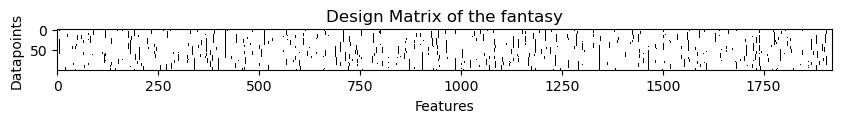

In [18]:
model=sk_model2(seq_nat.designM)
fantasy=model.gibbs_sampler(model.data[0,:], model.J,model.h, n_samples=100, n_gibbs_step=10, n_dropout=10)

#figure of the desugn matrix
fig2, ax2 = plt.subplots(figsize=(10,10))

ax2.imshow(fantasy, cmap='binary', interpolation='none')

ax2.set_ylabel('Datapoints')
ax2.set_xlabel('Features')
ax2.set_title('Design Matrix of the fantasy')

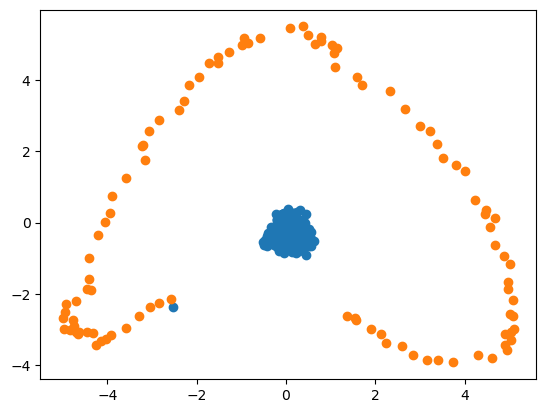

In [19]:
from sklearn.decomposition import PCA
pca = PCA(2)
twDfanta=pca.fit_transform(fantasy)
twDdata=pca.transform(seq_nat.designM)
plt.scatter(twDdata[:,0], twDdata[:,1], )
plt.scatter(twDfanta[:,0], twDfanta[:,1])

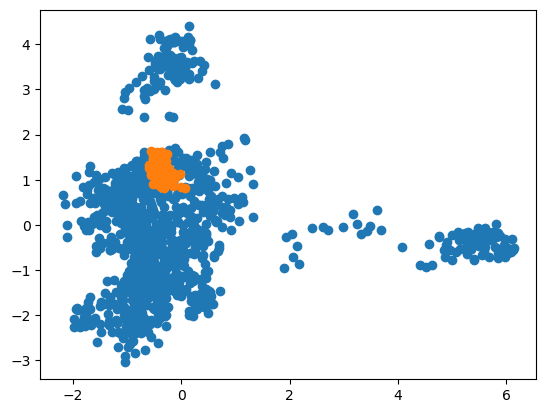

In [20]:
from sklearn.decomposition import PCA
pca = PCA(2)
twDdata=pca.fit_transform(seq_nat.designM)
twDfanta=pca.transform(fantasy)
plt.scatter(twDdata[:,0], twDdata[:,1])
plt.scatter(twDfanta[:,0], twDfanta[:,1])

In [21]:
model.fit_sgd(batch_size=10, eta=0.01, maxiter=100, tol=1e-3)

0
1


/var/folders/jk/fwlqxg255f12b5_dyr_f4_6w0000gn/T/ipykernel_1209/2931010027.py:159: RuntimeWarning: invalid value encountered in divide
  frequency[i*20:(i+1)*20] = frequency[i*20:(i+1)*20] / frequency[i*20:(i+1)*20].sum()


2


KeyboardInterrupt: 

In [ ]:
fantasy=model.gibbs_sampler(model.data[100,:], model.J, model.h, n_samples=500, n_gibbs_step=20, n_dropout=0)

from sklearn.decomposition import PCA
pca = PCA(2)
twDfanta=pca.fit_transform(fantasy)
twDdata=pca.transform(seq_nat.designM)
plt.scatter(twDdata[:,0], twDdata[:,1], )
plt.scatter(twDfanta[:,0], twDfanta[:,1])


In [ ]:
from sklearn.decomposition import PCA
pca2 = PCA(2)
twDdata=pca2.fit_transform(seq_nat.designM)
twDfanta=pca2.transform(fantasy)
plt.scatter(twDdata[:,0], twDdata[:,1])
plt.scatter(twDfanta[:,0], twDfanta[:,1])